In [1]:
#rah

**^^^ console ^^^**

### **IMPORTS**

In [2]:
# Core Python libraries
import os

# Scientific computing
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

# PyTorch core
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data import random_split


# Sklearn utilities
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Google Colab (if running in Colab)
from google.colab import drive

#MOUNT AND R/W DRIVE
drive.mount('/content/drive')
save_path = "/content/drive/MyDrive/Weights/best_model.pth"

#GPU or CPU  device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Mounted at /content/drive
Using device: cpu


### **DOWNLOAD DATA**

In [3]:
if not os.path.exists("data.hdf5"):
    !gdown https://drive.google.com/uc?id=1gl5W5PexON0wBfajUTPEkd9AiEnHo4rL -O data.hdf5


Downloading...
From (original): https://drive.google.com/uc?id=1gl5W5PexON0wBfajUTPEkd9AiEnHo4rL
From (redirected): https://drive.google.com/uc?id=1gl5W5PexON0wBfajUTPEkd9AiEnHo4rL&confirm=t&uuid=c15b06c2-4a46-410b-a5db-91d23e84f516
To: /content/data.hdf5
100% 263M/263M [00:04<00:00, 61.2MB/s]


### **NN MODEL**

In [4]:
class ImprovedModel(nn.Module):
    def __init__(self):
        super(ImprovedModel, self).__init__()

        # Increased layer width and depth
        self.fc1 = nn.Linear(52, 1024)
        self.bn1 = nn.BatchNorm1d(1024)
        self.dropout1 = nn.Dropout(0.1)  # Slightly increased

        self.fc2 = nn.Linear(1024, 512)
        self.bn2 = nn.BatchNorm1d(512)
        self.dropout2 = nn.Dropout(0.1)

        self.fc3 = nn.Linear(512, 128)
        self.bn3 = nn.BatchNorm1d(128)
        self.dropout3 = nn.Dropout(0.1)

        self.fc4 = nn.Linear(128, 32)  # Extra FC layer
        self.fc5 = nn.Linear(32, 1)  # Output layer

        self._initialize_weights()

    def forward(self, x):
        x = torch.nn.functional.silu(self.bn1(self.fc1(x)))
        x = self.dropout1(x)
        x = torch.nn.functional.silu(self.bn2(self.fc2(x)))
        x = self.dropout2(x)
        x = torch.nn.functional.silu(self.bn3(self.fc3(x)))
        x = self.dropout3(x)
        x = torch.nn.functional.silu(self.fc4(x))  # Extra layer
        x = self.fc5(x)

        return x

    def _initialize_weights(self):
        for layer in [self.fc1, self.fc2, self.fc3, self.fc4, self.fc5]:
            init.kaiming_normal_(layer.weight, nonlinearity='relu', mode='fan_out')
            init.constant_(layer.bias, 0)


### **INITIALISE VARIABLES**

In [5]:
# Initialize
model = ImprovedModel().to(device)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
criterion = nn.MSELoss().to(device)
lr = 0.00005
optimizer = torch.optim.Adam(model.parameters(), lr=0.00005, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100, eta_min=1e-7)
batch_size = 1028
best_loss = float("inf")
patience_counter = 0
patience = 50

### **LOAD DATA/PREPROCESSING/CREATE DATASET**

In [6]:
# 🚀 Load dataset
ds = xr.open_dataset("data.hdf5", engine="h5netcdf")

# 🚀 Select input features and target variable
X = ds["spectrum"].values.astype(np.float32)  # Ensure float32
y = ds["log_H2O"].values.astype(np.float32)   # Ensure float32

# 🚀 Fix: Check for NaNs and replace or remove them
if np.isnan(X).any() or np.isnan(y).any():
    print("Warning: NaN values detected! Replacing with mean...")
    X = np.nan_to_num(X, nan=np.nanmean(X))
    y = np.nan_to_num(y, nan=np.nanmean(y))

# 🚀 Fix: Normalize input features
scaler_X = StandardScaler()
X = scaler_X.fit_transform(X)

# 🚀 Fix: Normalize target variable (only if necessary)
scaler_y = StandardScaler()
y = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()  # Reshape before scaling

# 🚀 Fix: Split dataset properly
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# 🚀 Fix: Apply the SAME SCALERS to validation data
X_val = scaler_X.transform(X_val)  # Apply same transformation
y_val = scaler_y.transform(y_val.reshape(-1, 1)).flatten()  # Apply same transformation

# 🚀 Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)  # Fix shape

X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)      # Fix shape

# 🚀 Create PyTorch datasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

# 🚀 Load data into DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# 🚀 Print some debug info
print(f"Dataset Shapes: X_train {X_train.shape}, X_val {X_val.shape}")
print(f"Target Shapes: y_train {y_train.shape}, y_val {y_val.shape}")

print(f"X_train_tensor shape: {X_train_tensor.shape}")
print(f"y_train_tensor shape: {y_train_tensor.shape}")


Dataset Shapes: X_train (58490, 52), X_val (14623, 52)
Target Shapes: y_train (58490,), y_val (14623,)
X_train_tensor shape: torch.Size([58490, 52])
y_train_tensor shape: torch.Size([58490, 1])


### **VISUALISATION**

######################################################################
 Aundance of log_H2O in planetary atmosphere for planet 0 is -6.4848
######################################################################


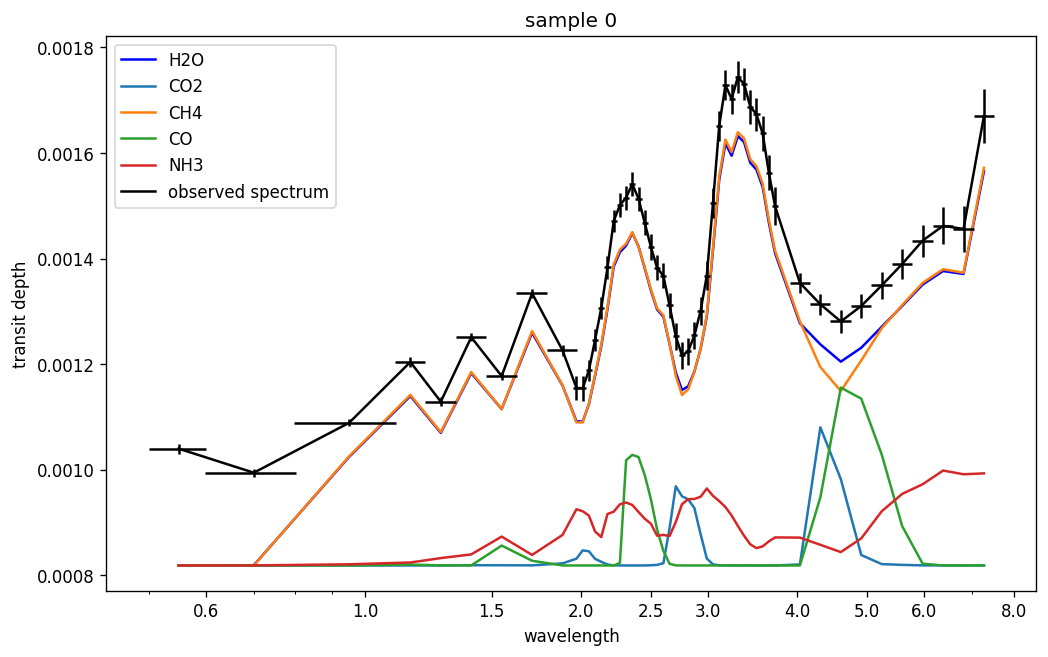

In [33]:
i = 0

plt.figure(figsize=(10, 6), dpi=120)
plt.plot(ds['wavelength'],ds['contributions'].sel(sample=i,species=['H2O']).values.T, label='H2O', color = 'b')
plt.plot(ds['wavelength'],ds['contributions'].sel(sample=i,species=['CO2']).values.T, label='CO2')
plt.plot(ds['wavelength'],ds['contributions'].sel(sample=i,species=['CH4']).values.T, label='CH4')
plt.plot(ds['wavelength'],ds['contributions'].sel(sample=i,species=['CO']).values.T, label='CO')
plt.plot(ds['wavelength'],ds['contributions'].sel(sample=i,species=['NH3']).values.T, label='NH3')
plt.plot(ds['wavelength'],ds['spectrum'].sel(sample=i).values, "k-", label='observed spectrum')

plt.errorbar(ds['wavelength'],ds['spectrum'].sel(sample=i).values,xerr=ds['bin_width']/2, yerr=ds['noise'].sel(sample=i).values, fmt='none', color='black', )


plt.xlabel('wavelength')
plt.ylabel('transit depth')

axs = plt.gca()
axs.set_xscale('log')
axs.set_xticks([0.6, 1,1.5, 2, 2.5,3,4, 5, 6,8,])
axs.get_xaxis().set_major_formatter(plt.ScalarFormatter())

plt.title(f'sample {i}')
plt.legend()


# print the species present in the sample
s_ = 'log_H2O'
print("#"*70)
print(f" Aundance of {s_} in planetary atmosphere for planet {i} is {ds[s_].sel(sample=i).values:.4f}")
print("#"*70)

### **CLASSES AND FUNCTIONS**

In [8]:
class EarlyStopping:
    def __init__(self, patience=100, min_delta=0.001):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = np.inf
        self.counter = 0

    def check_early_stop(self, current_loss):
        if current_loss < self.best_loss - self.min_delta:
            self.best_loss = current_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                print(f"Stopping early at epoch {epoch}!")
                return True
        return False

In [9]:
def plot_loss(losses, epoch):

    losses = np.array(losses)

    plt.figure()
    plt.plot(losses, "k-")

    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title(f'training loss\nepoch: {epoch}')

    plt.yscale('log')

    plt.ylim(losses.mean() - 3 * losses.std(), 4)

    plt.savefig('training_loss.png')
    plt.close()

def plot_valloss(losses, epoch):

    losses = np.array(losses)

    plt.figure()
    plt.plot(losses, "k-")

    plt.xlabel('epoch')
    plt.ylabel('val_loss')
    plt.title(f'Validation loss\nepoch: {epoch}')

    plt.yscale('log')

    plt.ylim(losses.mean() - 3 * losses.std(), 4)

    plt.savefig('validation_loss.png')
    plt.close()

def plot_predictions(predictions, labels, epoch):
    # make sure plot is square
    plt.figure(figsize=(5, 5))
    plt.plot(labels, predictions, "k.", label='predictions')
    plt.plot(labels, labels, "r--", label='Ground Truth')
    plt.xlabel('true log H2O value')
    plt.ylabel('predicted H2O value')
    plt.title(f'predictions\nepoch: {epoch}')

    plt.xlim(labels.min(), labels.max())
    plt.ylim(labels.min(), labels.max())

    plt.savefig('predictions.png')
    plt.close()



In [10]:
def save_checkpoint(epoch, model, optimizer, loss, save_path=save_path):
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss
    }, save_path)
    print(f"🔥 Saved New Best Model at Epoch {epoch} with Loss: {loss}")


In [11]:
def load_checkpoint(model, optimizer, path=save_path):
    if not os.path.exists(path):
        print("❌ No checkpoint found. Starting from scratch.")
        return 0, float('inf')
    try:
        checkpoint = torch.load(path, map_location=torch.device('cpu'), weights_only = False)  # Add map_location if using Colab
        model.load_state_dict(checkpoint["model_state_dict"])
        optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
        print(f"✅ Loaded Best Model from Epoch {checkpoint['epoch']} with Loss: {checkpoint['loss']}")
        return checkpoint["epoch"], checkpoint["loss"]
    except RuntimeError as e:
        print("⚠️ Checkpoint loading failed due to model mismatch or architecture change. Starting from scratch.")
        print(e)
        return 0, float('inf')


### **TRAINING SCRIPT**

In [34]:
train_losses = []
val_losses = []
batch_losses = []
epoch_losses = []
patience_counter = 0
patience = 50




try:
    start_epoch, best_loss = load_checkpoint(model, optimizer)
except RuntimeError as e:
    print("⚠️ Checkpoint loading failed due to model mismatch. Starting from scratch.")
    print(e)
    start_epoch = 0
    best_loss = float('inf')

early_stopping = EarlyStopping(patience=patience)

# 🚀 TRAINING LOOP
best_val_loss = float("inf")  # Track best validation loss

for epoch in range(start_epoch, 1000):
    model.train()
    batch_losses = []

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        batch_losses.append(loss.item())

    epoch_loss = np.mean(batch_losses)
    epoch_losses.append(epoch_loss)

    # 🔍 VALIDATION LOOP
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    # 💾 Save the best model based on VALIDATION loss
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        save_checkpoint(epoch, model, optimizer, epoch_loss)
        print(f"🔥 Saved New Best Model at Epoch {epoch} with Val Loss: {val_loss:.4f}")

    # Adjust learning rate
    scheduler.step()
    plot_loss(epoch_losses, epoch)
    plot_valloss(val_losses,epoch)
    plot_predictions(outputs.detach().cpu().numpy(), labels.detach().cpu().numpy(), epoch)


    # 📊 Logging
    print(f"Epoch {epoch}, Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}")

    # ⏹ Early stopping
    if early_stopping.check_early_stop(val_loss):
        print(f"⏹ Stopping Early at Epoch {epoch} (No Improvement for {patience} epochs), lr={lr}")
        break


✅ Loaded Best Model from Epoch 571 with Loss: 0.501735587391937


KeyboardInterrupt: 